# Frequency Domain Filtering

Normally, we think of an image as a rectangular array of pixels, each pixel representing an intensity at a position in the spatial domain. However, some denoising operations are complicated, or impossible to perform in the spatial domain.

The frequency domain is a space in which images are represented in terms of frequency rather than time. As such, the frequency domain representation reveals information about an image that is otherwise difficult to see, or not visible in the spatial domain. In particular, the frequency domain reveals the frequency with which pixel values change, information that is used as the basis for low-pass denoising algorithms. Many mathematical operations in the time domain have corresponding, and often simpler, operations in the frequency domain. For instance, convolution and differentiation in the time domain correspond to multiplication in the frequency domain.

We convert signals from the time domain into the frequency domain using a mathematical operation called the Fourier transform {cite}`fourierAnalyticalTheoryHeat2007`. Introduced by French mathematician Jean Baptiste Joseph Fourier in his 1822 book, La Théorie Analitique de la Chaleur (The Analytic Theory of Heat) {cite}`fourierAnalyticalTheoryHeat2007`, the Fourier transform allows any periodic function, no matter how complicated, to be expressed as the sum of sines and/or cosines of different frequencies, each multiplied by a different coefficient. Functions that are not periodic, but have finite area under the curve, can be expressed as the integral of sines and/or cosines multiplied by a weighting function.

Consequently, a function expressed as a Fourier transform can be reconstructed by an inverse transform in the spatial domain with no loss of information.

## Discrete Fourier Transform (DFT)

The discrete Fourier Transform (DFT) of an image $f(x,y)$ of size $M \times N$ is an image $F$ of the same size and is defined as:

```{math}
:label: dft
F(u,v) = \displaystyle\sum_{x=0}^{M-1}\displaystyle\sum_{y=0}^{N-1} f(x,y)e^{-j2\pi(\frac{ux}{M}+\frac{vy}{N})}
```

The *inverse* Discrete Fourier Transformation (IDFT), given by:

```{math}
:label: dft_inv
f(x,y) = \frac{1}{MN}\displaystyle\sum_{u=0}^{M-1}\displaystyle\sum_{v=0}^{N-1} F(u,v)e^{+j2\pi(\frac{ux}{M}+\frac{vy}{N})}
```

To get some intuition into the Fourier transform (FT) and the frequency domain representation, let’s plot a few FT images.

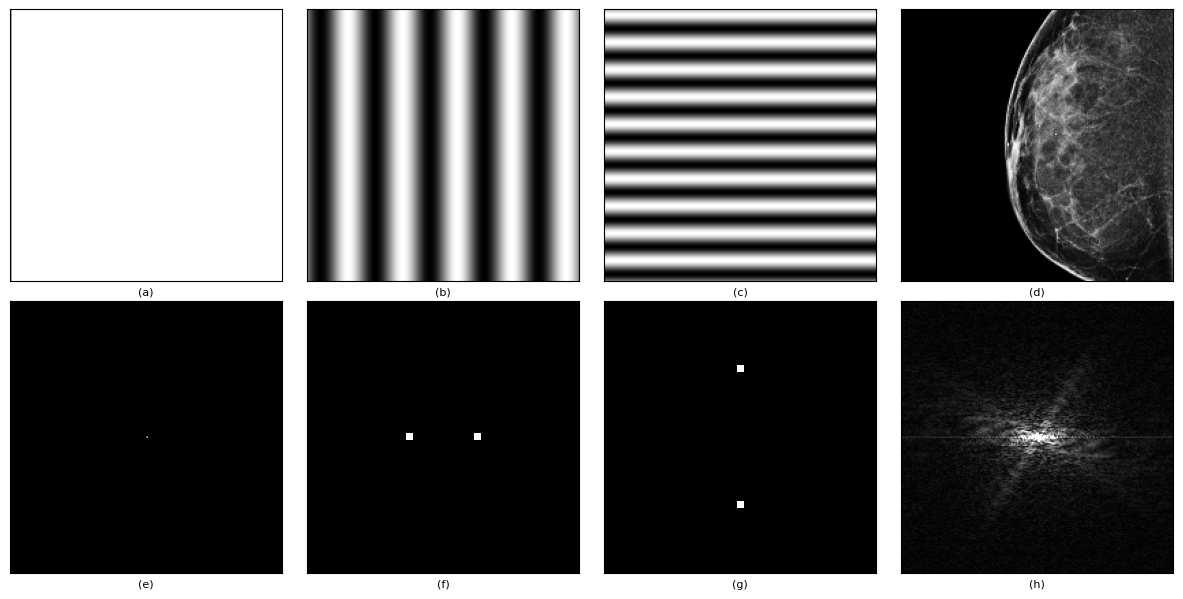

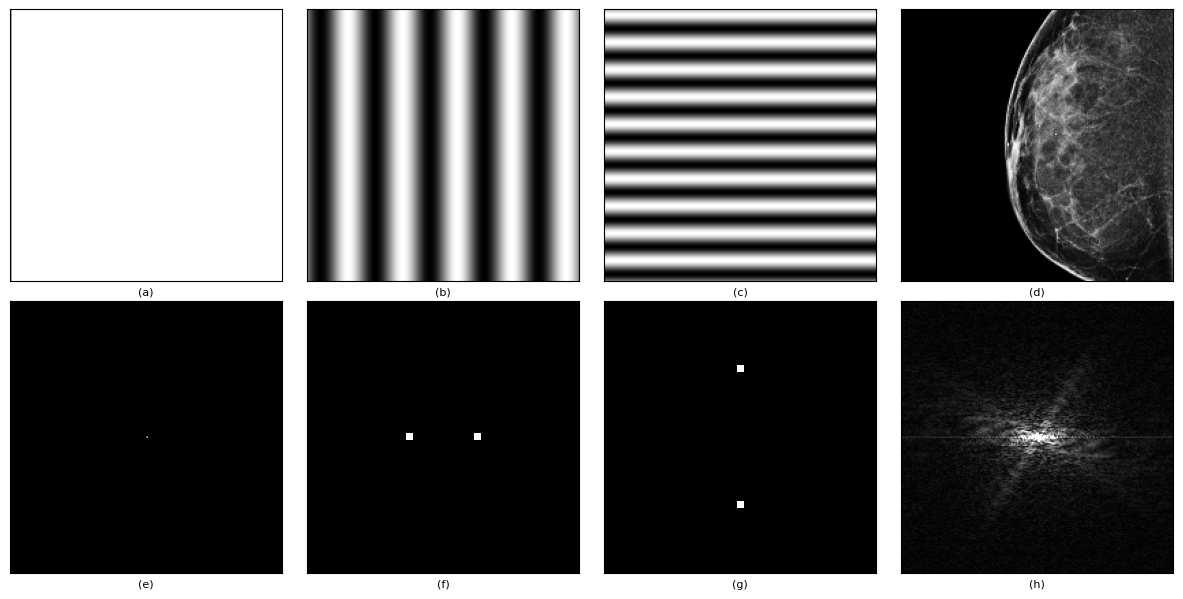

In [1]:
import os
if 'jbook' in os.getcwd():
    os.chdir(os.path.abspath(os.path.join("../../../..")))
import cv2
import matplotlib.pyplot as plt
import numpy as np
from bcd.utils.image import convert_uint8
from myst_nb import glue

FP_WHITE = "jbook/figures/frequency_white.jpg"
FP_MMG = "jbook/figures/mammogram.png"

def create_image(wavelength = 200, angle = 0):
    x = np.arange(-500,501,1)
    X,Y = np.meshgrid(x,x)
    return np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)

def get_image(fp: str, size: int = 200):
    img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
    return cv2.resize(img, (size,size))

def transform_image(img, log: bool = False, clip: bool = False):
    # Shift the input
    img = np.fft.ifftshift(img)
    # Compute fourier transformation
    img = np.fft.fft2(img)
    # Shift the zero-frequency to the center
    img = np.fft.fftshift(img)
    # Compute amplitude
    img = np.abs(img)
    # Convert to log to scale the image
    if log:
        img = np.log(img)
    # Clip the image for photos.
    if clip:
        img = np.clip(img, a_min=0, a_max=50000)

    return img


img_white = get_image(fp=FP_WHITE)
img_hline = create_image()
img_vline = create_image(angle=2 * np.pi / 4, wavelength=100)
img_mmg = get_image(fp=FP_MMG)

img_white_fft = transform_image(img_white)
img_hline_fft = transform_image(img_hline)
img_vline_fft = transform_image(img_vline)
img_mmg_fft = transform_image(img_mmg, clip=True)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
_ = axes[0,0].imshow(img_white, cmap='gray')
_ = axes[0,1].imshow(img_hline, cmap='gray')
_ = axes[0,2].imshow(img_vline, cmap='gray')
_ = axes[0,3].imshow(img_mmg, cmap='gray')

_ = axes[1,0].imshow(img_white_fft, cmap='gray')
_ = axes[1,1].imshow(img_hline_fft, cmap='gray')
_ = axes[1,1].set_xlim([480,520])
_ = axes[1,1].set_ylim([520,480])
_ = axes[1,2].imshow(img_vline_fft, cmap='gray')
_ = axes[1,2].set_xlim([520,480])
_ = axes[1,2].set_ylim([480,520])
_ = axes[1,3].imshow(img_mmg_fft, cmap='gray')

labels = np.array([["(a)", "(b)", "(c)", "(d)"], ["(e)", "(f)", "(g)", "(h)"]])
for i in range(2):
    for j in range(4):
        _ = axes[i,j].set_xlabel(labels[i,j])
        _ = axes[i,j].set_xticks([])
        _ = axes[i,j].set_yticks([])

plt.tight_layout()

glue("fft", fig)

```{glue:figure} fft
---
align: center
name: fft_fig
---
Discrete Fourier Transformation
```

In {numref}`fft_fig` we see a constant white image on the left, a vertical sinusoidal grating with a wavelength of 200 pixels (5 cycles), a horizontal sinusoidal grating with a wavelength of 100 pixels (10 cycles), and a mammogram on the top row, along with their frequency spectrum images on the second row.

The DFT of the white image (e) contains a single dot at the center (origin) of the frequency coordinate system. The color of the dot represents the average intensity in the image and its location indicates the amplitude of the zero-frequency wave, also called the direct current (DC) of the constant white image.

Moving to the right (f), we have the DFT for the vertical sinusoid. Notice The DFT has two dots placed symmetrically along the $u-axis$ about the center of the DFT image.  The distance each dot occupies from the origin indicates the frequency with which the intensities are changing.

In the next image (g), we have twice the number of cycles (1/2 wavelength), rotated $\frac{\pi}{2}$ radians. Notice in this case, the dots are oriented along the $v-axis$, the direction of the rate of change, and are twice the distance from the origin.

{numref}`fft_fig` (h) shows the DFT for a mammogram image. Notice, the single blob about the origin. Most 8-bit gray-scale images tend to have an average value of about 128, and lots of low-frequency information close to the origin.

The above examples illuminate the important properties of the frequency spectrum of an image:

- Rotating $f(x,y)$ by an angle $\theta_0$ rotates $F(u,v)$ by the same angle. Conversely, rotating $F(u,v)$ rotates $f(x,y)$ by the same angle,
- The center pixel of the spectrum image is the average color or gray-level intensity of the image.
- The frequency amplitude spectrum is symmetric about the center DC pixel. Hence, the amplitudes of a given frequency F, are contained in a ring of radius F about the center DC pixel.
- Lower frequencies will present as pairs of dots symmetrically placed a short distance from the origin; whereas, higher frequencies will render pairs of dots symmetrically placed at farther distances from the origin.

As a consequence of the above properties, smoothing, and denoising operations are achieved by high-frequency attenuation, i.e. low-pass filtering. Next, we describe the process by which filtering in the frequency domain is conducted.

## Filtering in the Frequency Domain

The process of filtering in the frequency domain is summarized as follows:

1. Given an input image $f(x,y)$ of size $M \times N$, obtain the padding sizes $P=2M$ and $Q=2N$.
2. Form a padded image $f_p(x,y)$ of size $P \times Q$ using zero, mirror, or replicate padding.
3. Shift $f_p(x,y)$ to center the Fourier transform on the  $P \times Q$ frequency rectangle.
4. Compute DFT, $F(u,v)$, of the shifted image $f_p(x,y)$.
5. Construct the real symmetric filter transfer function, $H(u,v)$ of size $P \times Q$ with center at ($P/2,Q/2).
6. Perform the element-wise product $G(u,v)=H(u,v)F(u,v)$ for $i=0,1,2,..,M-1$ and $k=0,1,2,...,N-1$
7. Obtain the frequency domain representation $g_p(x,y)$ by computing the IDFT of $G(u,v)$.
8. Extract the filtered image of size $M \times N$ from the top left quadrant of $g_p(x,y)$

Next, we will consider three types of frequency domain filters: the *ideal* filter, the Butterworth filter, and the Wavelet domain filter.

## Ideal Filter

The *ideal* filter attenuates unwanted frequencies from a signal while passing the wanted frequencies with uniform sensitivity. It has a ‘brick wall’ profile, in that the gain increases from zero at the stopband, to the higher gain of the passband at a single frequency. The ideal low-pass filter (ILPF) is defined by the following transfer function:

```{math}
:label: ideal_transfer
H(u,v) = \begin{cases}
    1 & if D(u,v) \le D_0 \\
    0 & if D(u,v) \gt D_0
\end{cases}
```

where $D_0$ is a positive constant, and $D(u,v)$ is the distance between a point $(u,v)$ in the frequency domain and the origin of the $P \times Q$ frequency rectangle; that is:

```{math}
:label: ideal_distance
D(u,v) = [(\mu-P/2)^2 + (v-Q/2)^2]^{1/2}
```

where $P=2M$ and $Q=2N$ are the padded sizes of the image.

{numref}`ideal_filter` shows an ideal filter transfer function as an image. All frequencies on or inside the circle of radius $D_0$ are passed; whereas, all frequencies outside the circle are completely attenuated.

```{figure} ../../../figures/ideal_filter.jpg
---
name: ideal_filter
---
Ideal Filter
```

The point of transition between the values $H(u,v)=1$ and $H(u,v)=0$ is called the *cutoff frequency*, the frequency at which the filter’s response drops off.

For a variety of reasons, the ideal filter cannot be realized; however, its behavior can be studied via simulation. And a characteristic of the ideal filter is significant 'ringing', which occurs when the impulse response oscillates at sharp transitions in the step function and increases with the amount of high-frequency content that is passed. This is an unacceptable aspect, particularly in medical imaging where artifacts can affect clinical diagnoses and outcomes.

The Butterworth low-pass filter which we will discuss next, avoids this phenomenon by decaying the impulse response.

## Butterworth Lowpass Filter

A 1930 paper by Stephen Butterworth, a British engineer and physicist {cite}`ctx8685948790003821` showed that an ideal filter could be approximated by a low-pass filter whose cutoff frequency was normalized to 1 radian per second. The Butterworth filter has a flat passband and a more gradual transition to the stopband, which eliminates the ringing artifacts characteristic of the ideal low-pass filter.

The Butterworth filter’s stopband begins at the cutoff frequency The roll-off rate, a measure of how quickly the filter’s response decreases as the frequency increases beyond the cutoff frequency, is controlled by the *order* of the filter. Higher order filters have a steeper roll-off rate, than lower order filters as shown in {numref}`butterworth_ideal`

```{figure} ../../../figures/butterworth.png
---
name: butterworth_ideal
---
Ideal Frequency Response for a Butterworth Filter
```

Note that the higher-order filters come closer to the ‘ideal’ response. The transfer function of an $n^{th}$ order Butterworth filter is given as:

```{math}
:label: butterworth_freq
H(u,v) = \frac{1}{1+[D(u,v)/D_0]^{2n}}
```

where $n$ represents the order of the filter, $D_0$ indicates the cutoff frequency at a distance $D_0$ from the origin, and $D(u,v)$ is given by {eq}`ideal_distance`. The spatial domain image obtained from the BLPF of order 1 has no ringing. At orders 2 and 3, ringing is imperceptible; however, ringing can be significant in filters of higher order.

{numref}`butterworth_characteristics_fig` illustrates the behavior of the Butterworth Filter on an image degraded by Gaussian noise. The order was set at 10, the cutoff frequency was set to 2000.

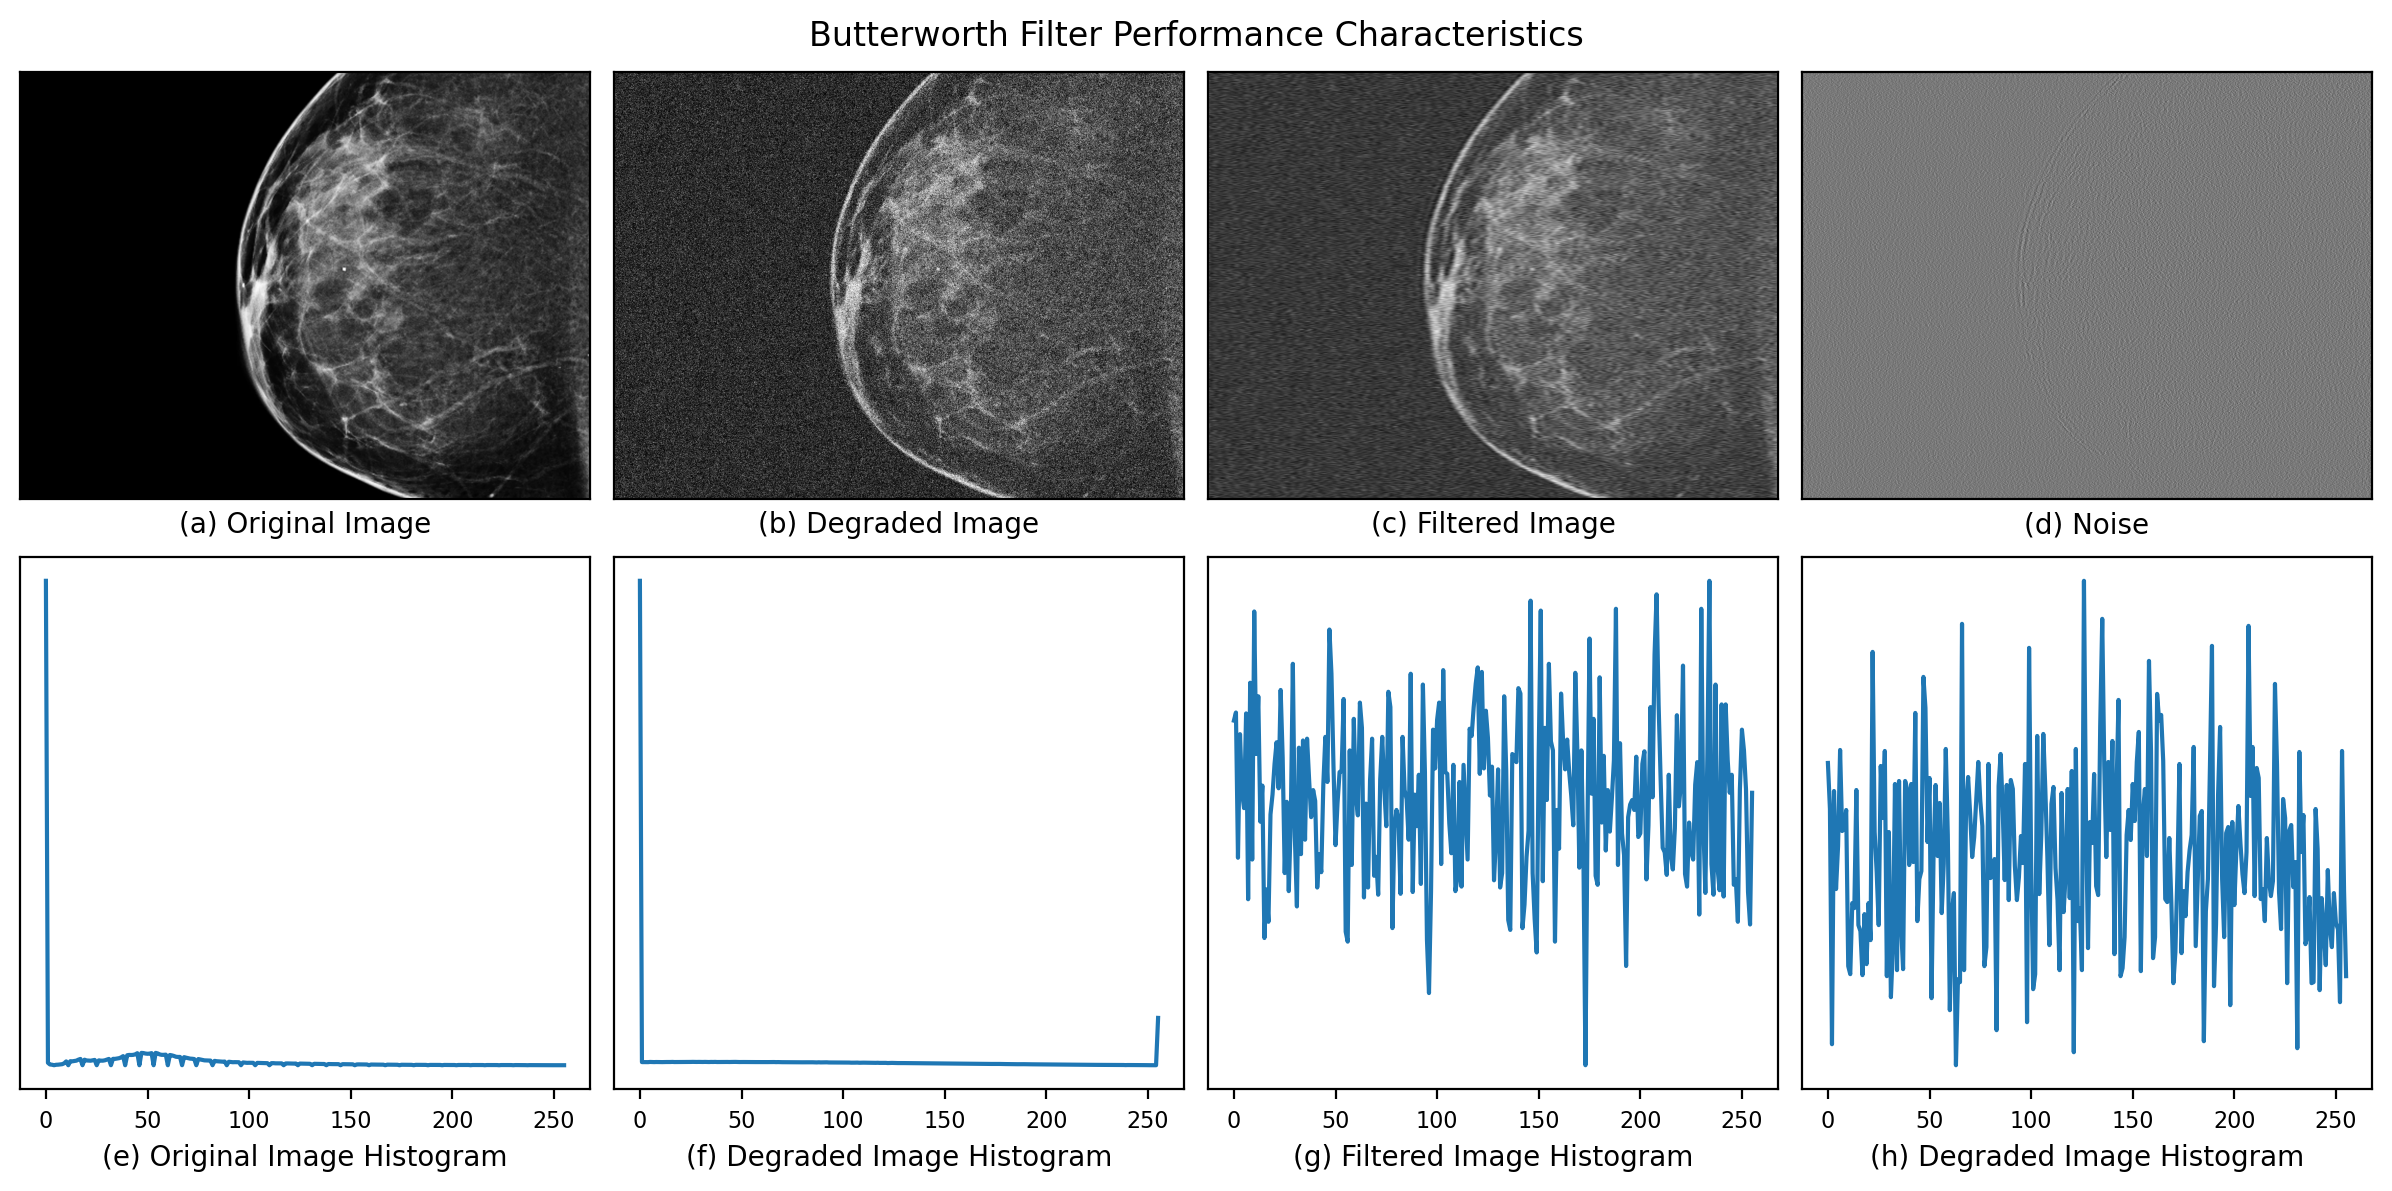

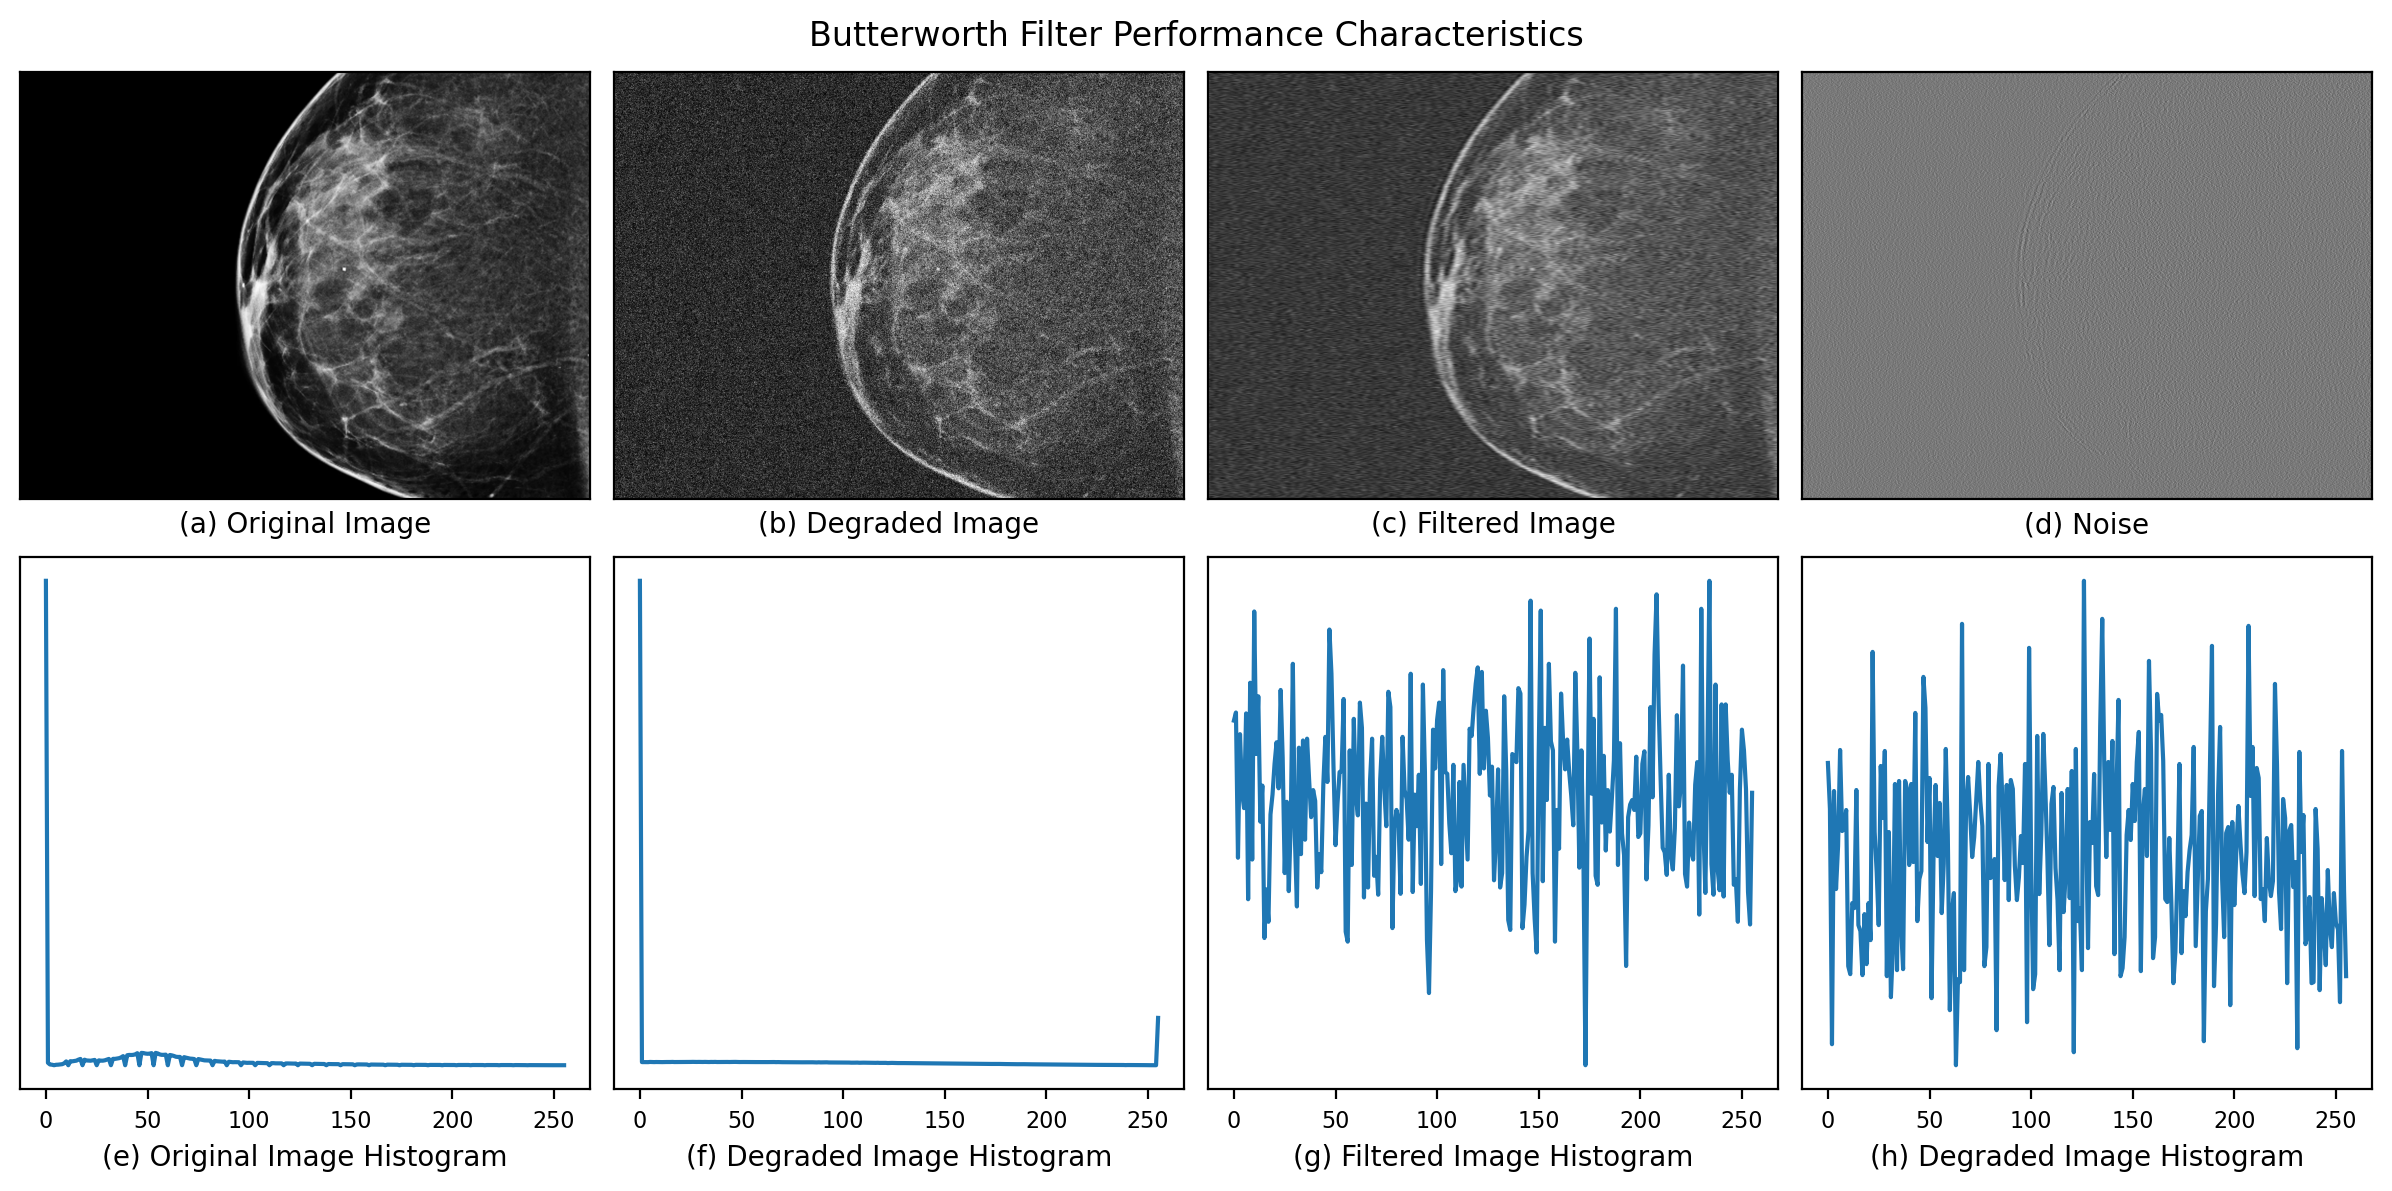

In [2]:
from bcd.preprocess.image.denoise.analyze import ButterworthFilterAnalyzer
analyzer = ButterworthFilterAnalyzer()
analyzer.add_gaussian_noise(var=0.2)
fig = analyzer.analyze(order=10, cutoff_frequency=2000)
glue("butterworth_characteristics", fig)

```{glue:figure} butterworth_characteristics
---
align: center
name: butterworth_characteristics_fig
---
Butterworth Filter Performance Characteristics with Gaussian Noise
```

{numref}`butterworth_characteristics_fig` shows almost no reduction in noise and a slight blurring effect is extant. {numref}`butterworth_analysis_fig` displays the behavior over a range of orders and cutoff frequencies.

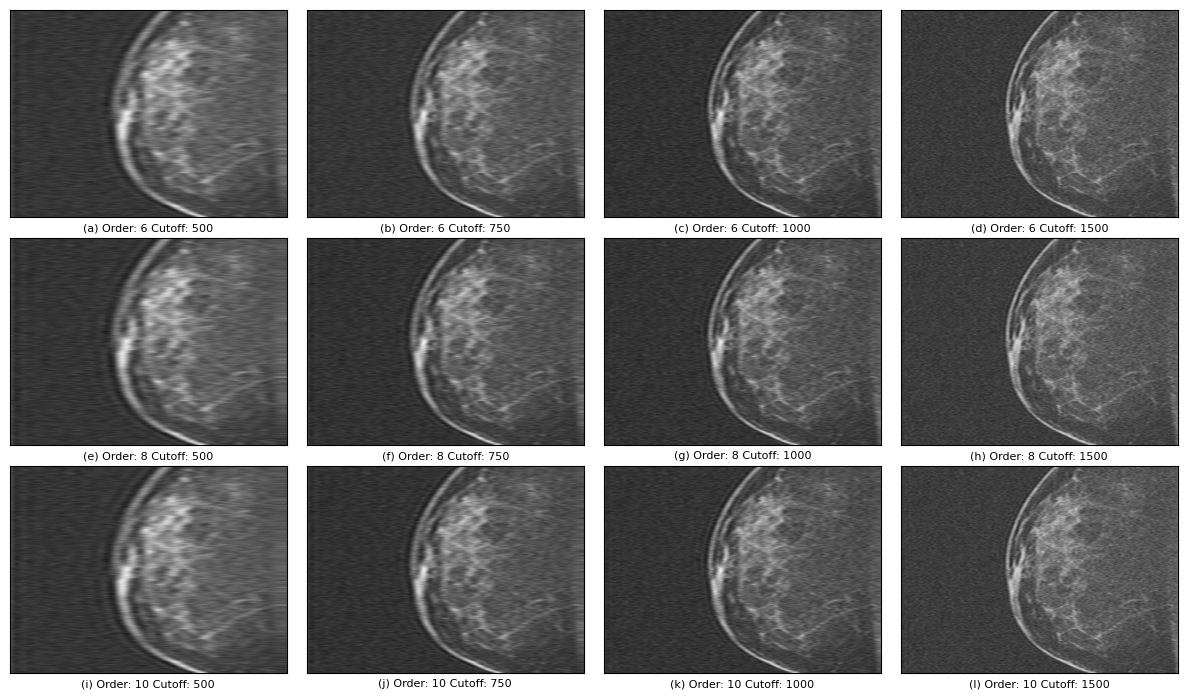

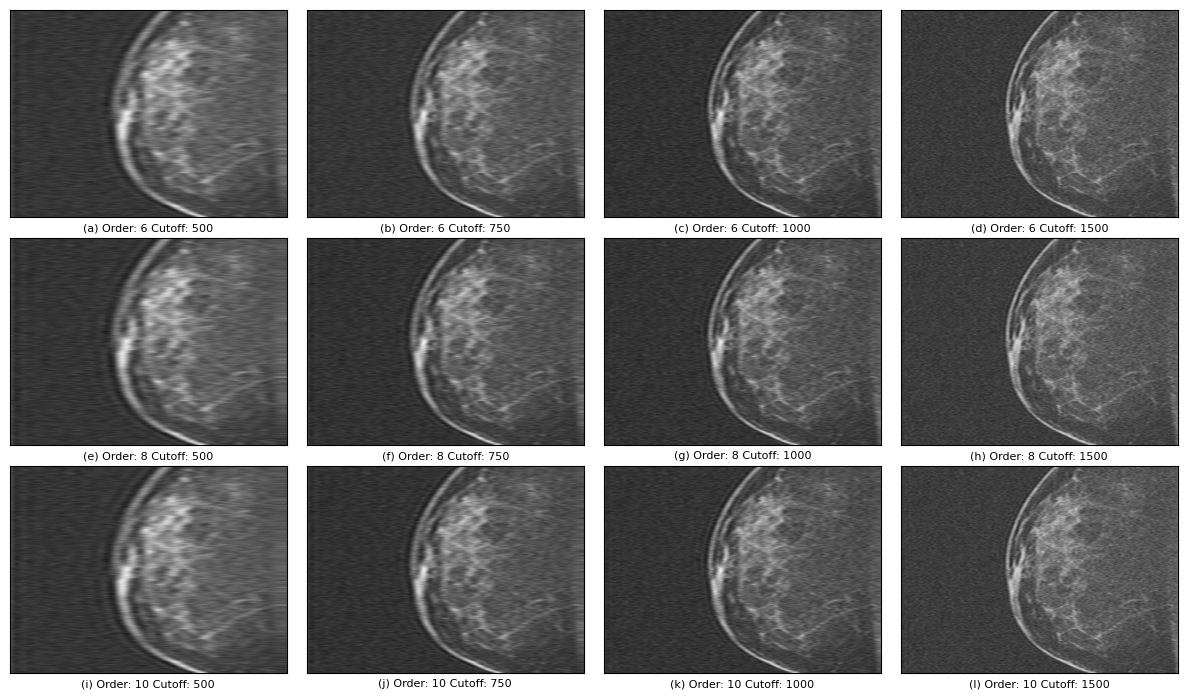

In [3]:
fig = analyzer.compare()
glue("butterworth_analysis", fig)

```{glue:figure} butterworth_analysis
---
align: center
name: butterworth_analysis_fig
---
Butterworth Filter Performance Analysis with Gaussian Noise
```

Order values were 6,8, and 10 for the first, second and third rows respectively. The frequency cutoffs were 500, 750, 1000 and 1500 for the first, second, third, and forth columns respectively. At the lower frequency cutoffs, we have a significant amount of blurring as well as apparent ringing effect, most notable at cutoff frequencies 500 and 750. Moving right, the blurring decreases; however, much of the Gaussian noise remains.

The Fourier transform expresses an image as a sum of sine and cosine waves, which go on 'forever', repeating out to positive and negative infinity. They are non-local, by definition and therefore they do not approximate sharp intensity changes very well. Next, we examine an alternative to Fourier transform-based denoisers based upon wavelets which are well-suited for approximating data with sharp discontinuities.

## Wavelet Denoising

Wavelet denoising is a non-parametric method that attempts to remove noise and retain the signal regardless of the frequency content of the signal.  Wavelets are small oscillating waveforms that begin from zero, reach a maximum, and then decay quickly back to zero; in contrast to sine and cosine waves which repeat from negative to positive infinity.

### Discrete Wavelet Transform

The Discrete Wavelet Transform (DWT) is the first step in image denoising; whereby, an image is decomposed into a sequence of low-frequency and high-frequency bands.

```{figure} ../../../figures/dwt.png
---
name: dwt
---
Discrete Wavelet Transform (2-Level)
```

As indicated in {numref}`dwt`, DWT first level decomposition separates the image into:

- low-frequency bands ($LL^1$) that approximate the original image;
- horizontal fluctuation detail containing both high and low frequencies ($LH^1$)
- vertical fluctuation detail containing both high and low frequencies ($HL^1$)
- diagonal fluctuation detail containing high-frequency information ($HH^1$)

The next level decomposition is applied to the $LL^1$ sub-band only.  This type of 2-D DWT produces a decomposition of approximation coefficients $CA_J$ at level $j$ in the four sub-bands: the approximation $CA_{j+1}$ and the details in three orientations: horizontal, vertical, and diagonal.

As mentioned before, noise tends to dominate high-frequency information. If an appropriate threshold $t$ can be set in the (horizontal, vertical, and diagonal) detail coefficients, we can drop the noise-contaminated detail coefficients to zero; thereby, removing the noise while preserving the signal.

### Threshold Selection and Application

Thresholding is the next step in wavelet image denoising. Core to wavelet denoising, threshold selection is the crucial ingredient in this procedure. Many threshold selection techniques have been proposed; withal, we will be exploring two methods commonly used in biomedical image processing: VisuShrink, and BayesShrink.

#### VisuShrink

VisuShrink {cite}`donohoIdealSpatialAdaptation1994`  uses a threshold $t$ that is proportional to the standard deviation of the noise. It is a hard threshold, and is defined by:

```{math}
:label: visushrink
t_v = \sigma \sqrt{2 log M}
```

where $\sigma$ is the noise variance present in the signal and $M$ represents the number of pixels in the image.

The noise level variance $\sigma$ is estimated by:

```{math}
:label: visushrink_noise
\sigma = \frac{(\text{median}|Y_{ij}|)}{0.06745}
```

where $Y_{ij} \in HH^1$.

This is a universal threshold for the removal of additive Gaussian noise. Specifying $\sigma$ at the noise variance can result in an overly smooth result. Often $\sigma$ less than the noise variance reduces noise while retaining fine detail.

{numref}`wavelet_visushrink_characteristics_fig`displays wavelet denoising using a VisuShrink threshold with $\sigma=0.15$  on Gaussian noise with $\sigma=0.2$

In [4]:
from bcd.preprocess.image.denoise.analyze import WaveletFilterAnalyzer
analyzer = WaveletFilterAnalyzer()
analyzer.add_gaussian_noise(var=0.2)
fig = analyzer.analyze(method='Visushrink', sigma=0.15)
glue("wavelet_visushrink_characteristics", fig)

ValueError: Invalid method: Visushrink. The currently supported methods are "BayesShrink" and "VisuShrink".

<Figure size 2400x1200 with 0 Axes>

```{glue:figure} wavelet_visushrink_characteristics
---
align: center
name: wavelet_visushrink_characteristics_fig
---
Wavelet Domain Filter Performance Characteristics with VisuShrink Threshold applied to Gaussian Noise
```

#### BayesShrink

The BayesShrink method {cite}`changAdaptiveWaveletThresholding2000` minimizes the Bayesian risk, hence the name. It is a subband-dependent, soft threshold, which means that the threshold is adapted to each band of resolution in the wavelet decomposition.  The BayesShrink threshold is given by:

```{math}
:label: bayesshrink
t_b = \frac{\sigma^2}{\sigma_s}
```

where $\sigma^2$ is the noise variance and $\sigma_s$ is the signal variance without noise. As with VisuShrink, the noise variance is estimated from the subband $HH^1$

{numref}`wavelet_bayesshrink_characteristics` displays a wavelet denoiser using BayesShrink threshold

In [ ]:
from bcd.preprocess.image.denoise.analyze import WaveletFilterAnalyzer
analyzer = WaveletFilterAnalyzer()
analyzer.add_gaussian_noise(var=0.2)
fig = analyzer.analyze(method='BayesShrink')
glue("wavelet_bayesshrink_characteristics", fig)

```{glue:figure} wavelet_bayesshrink_characteristics
---
align: center
name: wavelet_bayesshrink_characteristics_fig
---
Wavelet Domain Filter Performance Characteristics with BayesShrink Threshold applied to Gaussian Noise
```